In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab.ipynb")

ModuleNotFoundError: No module named 'otter'

# Lab 5 – Imputation

## DSC 80, Fall 2022

### Due Date: Monday, October 31st at 11:59 PM

## Instructions
Much like in DSC 10, this Jupyter Notebook contains the statements of the problems and provides code and Markdown cells to display your answers to the problems. Unlike DSC 10, the notebook is *only* for displaying a readable version of your final answers. The coding will be done in an accompanying `lab.py` file that is imported into the current notebook.

<span style='color:red'><b>Note: For Lab 5 only, there are no hidden tests!</b></span> The tests you see when you run `grader.check` are the final tests that will determine your grade. In addition, when you submit Lab 5 to Gradescope you will see your final score on the assignment right away. (This is because the lab is due very close to the Midterm Exam.)

Labs and programming assignments will be graded in (at most) two ways:
1. The functions and classes in the accompanying `lab.py` file will be tested (a la DSC 20),
2. The notebook may be graded (if it contains free response questions or asks you to draw plots).

**Do not change the function names in the `lab.py` file!**
- The functions in the `lab.py` file are how your assignment is graded, and they are graded by their name.
- If you changed something you weren't supposed to, just use git to revert! Ask us if you need help with this, or google around for `git revert`.

**Tips for working in the notebook**:
- The notebooks serve to present the questions and give you a place to present your results for later review.
- The notebooks in *lab assignments* are not graded (only the `lab.py` file is submitted and graded).
- The notebook serves as a nice environment for 'pre-development' and experimentation before designing your function in your `lab.py` file. You can write code here, but make sure that all of your real work is in the `lab.py` file.

**Tips for developing in the `lab.py` file**:
- Do not change the function names in the starter code; grading is done using these function names.
- Do not change the docstrings in the functions. These are there to tell you if your work is on the right track!
- You are encouraged to write your own additional helper functions to solve the lab! 
- Always document your code!

### Importing code from `lab.py`

* We import our `lab.py` file that's contained in the same directory as this notebook.
* We use the `autoreload` notebook extension to make changes to our `lab.py` file immediately available in our notebook. Without this extension, we would need to restart the notebook kernel to see any changes to `lab.py` in the notebook.
    - `autoreload` is necessary because, upon import, `lab.py` is compiled to bytecode (in the directory `__pycache__`). Subsequent imports of `lab` merely import the existing compiled python.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from lab import *

In [4]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import requests
import bs4

***Note:*** While working on the lab, check the Campuswire post titled "Lab 5 Released!" for any clarifications.

## Question 1 – Payment Data 💰

In `data/payment.csv`, you are given a dataset of payment information for purchases made on January 1st, 2019. The dataset contains the purchaser's `'Id'`, `'credit_card_type'`, `'credit_card_number'`, and `'date_of_birth'`.

Your job is to assess the missingness in the payments data. The question you need to answer is, **is `'credit_card_number'` missing at random dependent on the age of the shopper?**. Let's approach this question in two ways.

#### `first_round`

Look at distribution of ages by missingness of `'credit_card_number'` and determine if the missingness is dependent on age or not.

Use the following steps to approach this problem:

- Compute the ages of the purchasers.
- Draw the distribution of ages by missingness of `'credit_card_number'`. Specifically, you will draw two histograms or density curves:
    - One of ages where `'credit_card_number'` is missing.
    - One of ages where `'credit_card_number'` is not missing.
- Perform a permutation test for whether or not the two distributions mentioned above are drawn from the same population distribution. Use a 5% significance level. Use the **absolute difference of means** as your test statistic.

Write a function `first_round` with no arguments that returns a **list** with two values:
* The first value is the p-value from your permutation test. 
* The second value is either `'R'` if you reject the null hypothesis, or `'NR'` if you fail to reject the null.

**Does the result match your guess? If not, what might be a problem?**

***Hint:*** 
- Look at [Lecture 8](https://github.com/dsc-courses/dsc80-2022-fa/tree/main/lectures/08-missingness/notebook/lecture.ipynb).
- To find a customer's age, compute the number of years between their birth year and 2022.

<br>

#### `second_round`

Run another permutation test for the empirical distribution of age conditional on `'credit_card_number'` with a 5% significance level. This time, use the **Kolmogorov-Smirnov statistic** as your test statistic.

Write a function `second_round` with no arguments that returns a __list__ with three values: 
* The first value is the p-value from your new permutation test.
* The second value is either `'R'` if you reject the null hypothesis, or `'NR'` if you fail to reject the null. 
* The third value is your final conclusion: `'D'` (the missingness of `'credit_card_number'` is dependent on age) or `'ND'` (the missingness of `'credit_card_number'` is not dependent on age).

***Hint:*** 
- In [Lecture 8](https://github.com/dsc-courses/dsc80-2022-fa/tree/main/lectures/08-missingness/notebook/lecture.ipynb), we ran permutation tests using the Kolmogorov-Smirnov test statistic **without `for`-loops**. You can use this same procedure; we have already imported `stats` from `scipy`.

In [5]:
# Run your permutation tests in the Jupyter Notebook;
# put your final results in lab.py
payments_fp = os.path.join('data', 'payment.csv')
payments = pd.read_csv(payments_fp)
payments.head()

,id,credit_card_type,credit_card_number,date_of_birth
0,1,diners-club-enroute,2.018706e+14,25-Sep-1982
1,2,americanexpress,3.737511e+14,08-Jan-1946
2,3,jcb,3.570296e+15,NaN
3,4,mastercard,5.318327e+15,NaN
4,5,maestro,6.759827e+17,20-Apr-1975


(0.1291, 0.4627416897959975)

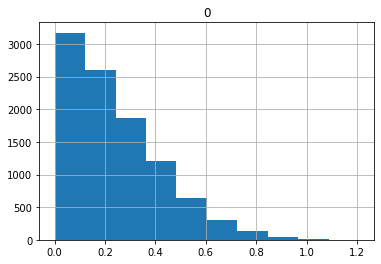

In [48]:
df = payments.copy(deep=True)
df['date_of_birth'] = df['date_of_birth'].astype(np.datetime64)
df['age'] = (
            np.datetime64(52,'Y') - 
            df['date_of_birth'].astype('datetime64[Y]')
            ).astype('timedelta64[Y]')
df2 = df.dropna(axis = 0, subset=['credit_card_number'])


observed = np.abs(df['age'].mean()-df2['age'].mean())
observed

trials = []
for i in range(10000):
    tdf = df.copy()
    tdf['age'] = np.random.permutation(tdf['age'])
    tdf2 = tdf.dropna(axis = 0, subset=['credit_card_number'])

    trial = np.abs(tdf['age'].mean()-tdf2['age'].mean())

    trials.append(trial)

trials = np.array(trials)

p = np.count_nonzero(trials >= observed)/10000

pd.DataFrame(data=trials).hist()
p, observed

In [234]:
from scipy.stats import ks_2samp

df = payments.copy(deep=True)
df['date_of_birth'] = df['date_of_birth'].astype(np.datetime64)
df['age'] = (
            np.datetime64(52,'Y') - 
            df['date_of_birth'].astype('datetime64[Y]')
            ).astype('timedelta64[Y]')
df2 = df.dropna(axis = 0, subset=['credit_card_number'])

obs = ks_2samp(df['age'],df2['age']).pvalue
1-obs

0.0028277628406094824

In [7]:
# don't change this cell, but do run it -- it is needed for the tests to work
first_pval, first_result = first_round()
second_pval, second_result, second_result1 = second_round()

In [ ]:
grader.check("q1")

## Question 2 – Missing Heights 🕵️

In the file `data/missing_heights.csv` are the heights of children and their fathers (`'child'` and `'father'`). The `'child_X'` columns are missing values in varying proportions; for each X, `'child_X'` is X\% not missing (and hence (100-X)\% missing). The missingness of these `'child_X'` columns were created as MAR dependent on `'father'` height (similar to what was done in Lecture 12). The missingness of these `'child_X'` columns are all equally dependent on father height.

You will attempt to **verify** the missingness of the `'child_X'` columns as being dependent on the `'father'` height column by using permutation tests. Your permutation tests should use the Kolmogorov-Smirnov test statistic. You can use `scipy.stats`' built-in K-S function to run your permutation tests and compute your p-values; you don't need to simulate manually using a `for`-loop.

#### `verify_child`

Write a function `verify_child` that takes in the `heights` DataFrame and returns a Series of p-values from your permutation tests, indexed by the columns `'child_X'`.

***Notes:*** 

- Unlike in Question 1, your permutation tests should run within your `verify_child` function.
- You may loop over the **columns** of `heights`.

<br>

#### `missing_data_amounts`

Now, interpret your results. In the function `missing_data_amounts`, return a __list__ of correct statements from the options below:
1. The p-value for `'child_50'` is small because the *sampling distribution* of test statistics has low variance.
2. MAR is hardest to determine when there are very different proportions of missing and not-missing values.
3. The difference between p-values for `'child_5'` and `'child_95'` is due to randomness.
4. We should expect the p-value of `'child_X'` and `'child_(100-X)'` to be similar.
5. We should only expect the p-value of `'child_X'` and `'child_(100-X)'` to be similar if the columns are MCAR.

In [249]:
heights_fp = os.path.join('data', 'missing_heights.csv')
heights = pd.read_csv(heights_fp)
heights

from scipy.stats import ks_2samp

out = pd.Series(index=heights.columns, dtype=np.float64)
out

for column in heights.columns:
    t = heights[column]
    t2 = heights[column].dropna()
    out[column] = 1-ks_2samp(t,t2).pvalue

pd.DataFrame(out)

out

child       0.000000
father      0.000000
child_95    0.809456
child_90    0.999720
child_75    1.000000
child_50    1.000000
child_25    1.000000
child_10    1.000000
child_5     1.000000
dtype: float64

In [61]:
1.905442e-01

0.1905442

In [22]:
# don't change this cell, but do run it -- it is needed for the tests to work
heights_fp = os.path.join('data', 'missing_heights.csv')
heights = pd.read_csv(heights_fp)
out1_q2 = verify_child(heights.copy())
out2_q2 = missing_data_amounts()

In [ ]:
grader.check("q2")

## Question 3 – Imputing Heights 🧍📏

In [Lecture 9](https://github.com/dsc-courses/dsc80-2022-fa/tree/main/lectures/09-data_imputation/notebook/lab.ipynb), you learned how to perform single-valued imputation conditionally on a **categorical** column: impute with the mean for each group. That is, for each distinct value of the **categorical** column, there is a single imputed value.

Here, you will perform single-valued imputation conditionally on a **quantitative** column. 

You will work with a version of the `heights` DataFrame, `new_heights`, that has a `'father'` column and a single `'child'` column. The `'child'` column has missing values. To impute the `'child'` column, transform the `'father'` column into a categorical column by binning the values of `'father'` into [quartiles](https://en.wikipedia.org/wiki/Quartile). Once this is done, you can impute `'child'` as in lecture (and described above).

<br>

#### `cond_single_imputation`

Write a function `cond_single_imputation` that takes in a DataFrame with columns `'father'` and `'child'` (where `'child'` has missing values) and performs a single-valued mean imputation of the `'child'` column, conditional on `'father'`. Your function should return a **Series**.

***Hints:*** 
- `pd.qcut` may be helpful!
- The `transform` is useful for this question (see [Lecture 5](https://github.com/dsc-courses/dsc80-2022-fa/blob/main/lectures/05-grouping/notebook/lecture.ipynb)), though it's also possible using `aggregate`. 
- As a reminder, *loops are not allowed*, and functions mentioned in "Hints" are not required.

In [264]:
heights_fp = os.path.join('data', 'missing_heights.csv')
new_heights = pd.read_csv(heights_fp)[['father', 'child_50']]
new_heights = new_heights.rename(columns={'child_50': 'child'})
new_heights


df = new_heights.copy()
df['father'] = pd.qcut(df['father'], 4)


out = df.groupby('father').mean()['child']

out


father
(61.999, 68.0]    65.481383
(68.0, 69.0]      66.933750
(69.0, 71.0]      67.434307
(71.0, 78.5]      68.083871
Name: child, dtype: float64

In [268]:
heights_fp = os.path.join('data', 'missing_heights.csv')
new_heights = pd.read_csv(heights_fp)[['father', 'child_50']]
new_heights = new_heights.rename(columns={'child_50': 'child'})
new_heights


df = new_heights.copy()
df['father'] = pd.qcut(df['father'], 4)


out = df.groupby('father').mean()['child']

df2 = df.apply(lambda row: out[row['father']] if np.isnan(row['child']) else row['child'],axis=1)
df2

0      68.083871
1      68.083871
2      69.000000
3      69.000000
4      73.500000
         ...    
929    64.000000
930    62.000000
931    65.481383
932    66.500000
933    65.481383
Length: 934, dtype: float64

In [233]:
def cond_single_imputation(new_heights):
    """
    cond_single_imputation takes in a DataFrame with columns 
    father and child (with missing values in child) and imputes 
    single-valued mean imputation of the child column, 
    conditional on father. Your function should return a Series.

    :Example:
    >>> heights_fp = os.path.join('data', 'missing_heights.csv')
    >>> new_heights = pd.read_csv(heights_fp)[['father', 'child_50']]
    >>> new_heights = new_heights.rename(columns={'child_50': 'child'})
    >>> out = cond_single_imputation(new_heights.copy())
    >>> out.isna().sum() == 0
    True
    >>> (new_heights['child'].std() - out.std()) > 0.5
    True
    """
    df = new_heights.copy()
    df['father'] = pd.qcut(df['father'], 4)

    out = df.groupby('father').mean()['child']
    return out
out = cond_single_imputation(new_heights.copy())
np.isclose(out.mean(), new_heights.mean(),atol=0.2)

array([False, False])

In [236]:
def answers():
    """
    Returns two lists with your answers
    :return: Two lists: one with your answers to multiple choice questions
    and the second list has 6 websites that satisfy given requirements.
    >>> mc_answers, websites = answers()
    >>> len(mc_answers)
    4
    >>> len(websites)
    6
    """
    mc_answers = [1,2,2,1]
    websites = ['https://www.cnn.com/robots.txt', 
                'https://www.reddit.com/robots.txt',
                'https://www.ebay.com/robots.txt',
                'https://docs.google.com/robots.txt',
                'https://stockx.com/robots.txt',
                'https://twitter.com/robots.txt'
                ]
    return mc_answers, websites

mc_answers, websites = answers()

In [37]:
# don't change this cell, but do run it -- it is needed for the tests to work
heights_fp = os.path.join('data', 'missing_heights.csv')
new_heights = pd.read_csv(heights_fp)[['father', 'child_50']]
new_heights = new_heights.rename(columns={'child_50': 'child'})
out_q3 = cond_single_imputation(new_heights.copy())

In [38]:
# don't change this cell, but do run it -- it is needed for the tests to work
heights_q3 = pd.read_csv('data/missing_heights.csv')
heights_q3['child'] = heights_q3['child_50']
inp_q3 = heights_q3
out_q3 = cond_single_imputation(inp_q3)
df_q3 = inp_q3.copy()
df_q3['imputed'] = out_q3
gp1_q3 = df_q3.groupby('father')['imputed'].mean()
gp2_q3 = df_q3.groupby('father')['child'].mean()
m_q3 = (pd.concat([gp1_q3, gp2_q3], axis=1)
     .dropna().diff(axis=1).abs().iloc[:, -1])

In [ ]:
grader.check("q3")

## Question 4 – Probabilistic Imputation 🎲

In [Lecture 9](https://github.com/dsc-courses/dsc80-2022-fa/tree/main/lectures/09-data_imputation/notebook/lab.ipynb), you learned how to impute a quantitative column by sampling from the observed values. **One problem with this technique is that the imputation will never generate imputed values that weren't already in the dataset.** For example, 57, 57.5, and 59 are values in the `'child'` column of `new_heights` while 58 is not. Thus, any imputation done by sampling from the observed values in the `'child'` column will not be able to generate a height of 58, even though it's clearly a reasonable value to occur in the dataset.

To keep things simple, you will impute the `'child'` column **unconditionally** from the distribution of `'child'` heights present in the dataset. This means that you will use the values present in `'child'` to impute missing values, without looking at other columns.

An approach to quantitative imputation that overcomes the limitation mentioned above is as follows:
- Create a histogram of observed `'child'` heights, using 10 bins.
- Use the histogram to generate a number within the observed range of `'child'` heights:
    - The likelihood a generated number belongs to a given bin is equal to the area of that bin. (Remember, in histograms, areas are proportions.)
    - Any number within a fixed bin is equally likely to occur.
    
Let's illustrate this approach with an example. Let `demo` be the array of 10 numbers defined below.

```py
demo = np.array([10, 11, 11, 13, 14, 14, 13.5, 14, 15, 16])
```

- The first step is creating a histogram of `demo`. Note that with this small dataset, we will use 3 bins, but you will be using 10 bins in your imputation process.

<img src='imgs/demo_histogram.png' width=300>

- Note that in your process, you don't actually need to draw a histogram – instead, use `np.histogram`.
- In the histogram above, we see that $2 \cdot 0.15 = 0.3 = 30\%$ of values lie in the [10, 12) bin, $2 \cdot 0.1 = 0.2 = 20\%$ of values lie in the [12, 14) bin, and $2 \cdot 0.25 = 0.5 = 50\%$ of values lie in the [14, 16] bin.
- Next, we need to pick a bin at random. There's a 30\% chance we pick the [10, 12) bin, a 20\% chance we pick the [12, 14) bin, and a 50\% chance we pick the [14, 16] bin. `np.random.choice` will be helpful in picking a bin at random.
- Once we pick a bin, we pick a number **uniformly at random** from within the bin. For instance, suppose we randomly chose the [14, 16] bin in the previous step. We then must select a (real) number between 14 and 16 uniformly at random. `np.random.uniform` can help you here.

<br>

#### `quantitative_distribution`
    
Create a function `quantitative_distribution` that takes in a Series, `child`, in which some values are missing, and an integer `N > 0`, and returns an **array** of `N` imputed values using the method described above. 

***Note:*** You may use a `for`-loop.

<br>

#### `impute_height_quant`

Create a function `impute_height_quant` that takes in a Series, `child`, in which some values are missing and imputes them using the scheme above. `impute_height_quant` should return a Series that is the same length of `child` but with no missing values. **You should use `quantitative_distribution` to help you do this.**

In [226]:
child = heights['child_50']



child = child
childnona = child.dropna()
probs, bins = np.histogram(childnona, density= True)

binsbins = {}
for i in range(len(bins)):
    if len(bins) - i != 1:
        binny = (bins[i], bins[i+1])
        binsbins[i] = binny
    else:
        break


randbins = np.random.choice(a=len(probs), size=100, p=probs/probs.sum())

out = []


for binn in randbins:
    edges = binsbins[binn]
    hite = round(np.random.uniform(edges[0],edges[1]),1)
    out.append(hite)

out



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [247]:
def quantitative_distribution(child, N):
    """
    quantitative_distribution that takes in a Series and an integer 
    N > 0, and returns an array of N samples from the distribution of 
    values of the Series as described in the question.
    :Example:
    >>> heights_fp = os.path.join('data', 'missing_heights.csv')
    >>> heights = pd.read_csv(heights_fp)
    >>> child = heights['child_50']
    >>> out = quantitative_distribution(child, 100)
    >>> out.min() >= 56
    True
    >>> out.max() <= 79
    True
    >>> np.isclose(out.mean(), child.mean(), atol=1)
    True
    >>> np.isclose(out.std(), 3.5, atol=0.65)
    True
    """
    if N == 0:
        return
    childnona = child.dropna()
    probs, bins = np.histogram(childnona, density= True)

    binsbins = {}
    for i in range(len(bins)):
        if len(bins) - i != 1:
            binny = (bins[i], bins[i+1])
            binsbins[i] = binny
        else:
            break


    randbins = np.random.choice(a=len(probs), size=N, p=probs/probs.sum())

    out = []


    for binn in randbins:
        edges = binsbins[binn]
        hite = round(np.random.uniform(edges[0],edges[1]),1)
        out.append(hite)

    out = np.array(out)
    return out

heights_fp = os.path.join('data', 'missing_heights.csv')
heights = pd.read_csv(heights_fp)
child = heights['child_50']

childnona = np.array(child.dropna())
N = child.isna().sum()
heights = quantitative_distribution(child,N)

out = np.concatenate([childnona, heights])
pd.Series(out)


def impute_height_quant(child):
    """
    impute_height_quant takes in a Series of child heights 
    with missing values and imputes them using the scheme in
    the question.
    :Example:
    >>> heights_fp = os.path.join('data', 'missing_heights.csv')
    >>> heights = pd.read_csv(heights_fp)
    >>> child = heights['child_50']
    >>> out = impute_height_quant(child)
    >>> out.isna().sum() == 0
    True
    >>> np.isclose(out.mean(), child.mean(), atol=0.5)
    True
    >>> np.isclose(out.mean(), child.mean(), atol=0.2)
    True
    >>> np.isclose(out.std(), child.std(), atol=0.15)
    True
    """
    childnona = np.array(child.dropna())
    N = child.isna().sum()
    heights = quantitative_distribution(child,N)

    out = pd.Series(np.concatenate([childnona, heights]))
    return out




In [248]:
# don't change this cell, but do run it -- it is needed for the tests to work
heights_fp = os.path.join('data', 'missing_heights.csv')
heights = pd.read_csv(heights_fp)
child = heights['child_50']
quantitative_distribution_out_q4 = quantitative_distribution(child.copy(), 100)
impute_height_quant_out_q4 = impute_height_quant(child.copy())
np.isclose(quantitative_distribution_out_q4.std(), 3.5, atol=0.65)

True

In [ ]:
grader.check("q4")

## Question 5 – The Rules of Web Scraping 🚔

In Lecture 14, we will start studying web scraping. This question will give you an introduction to the rules behind it.

Many sites have a published policy allowing or disallowing automatic access to their site. Often, this policy is in a text file named `robots.txt`. [Here is a good article](https://moz.com/learn/seo/robotstxt) that explains what these files are, where to find them, and how to use them. **After reading the article**, please answer the following questions.

<br>

### Multiple-Choice Questions

**1. What is the purpose of `robots.txt`?**

1. To informs agents which pages to crawl.

2. To informs agents that the site is automated.

3. To inform agents that robots will chase them down if their info is stolen.


**2. Where do you put your `robots.txt` file?**

1. In the folder you want to disallow.

2. In the root directory of your website.

3. In a Google search.

**3. Is it illegal to scrape a site if there is no `robots.txt` present?** (***Hint:*** [Read this](https://medium.com/@tjwaterman99/web-scraping-is-now-legal-6bf0e5730a78) if you're not sure. If you aren't able to access the article because Medium says "You've read all your free member-only stories...", try opening the article in a new incognito or private browsing window 😅.)

1. Yes.

2. No.

**4. Can each subdomain on a root domain use separate `robots.txt` files?**

1. Yes.

2. No.


<br>


### Website Hunt

Next, **find three websites that explicitly use a `robots.txt` file and allow scraping by everyone, and three that do not allow scraping by generic user-agents**.

When browsing through `robots.txt` files, you may notice that some have entries for several different user-agents. The user-agent you are interested in for this question is the generic user-agent, which is denoted by `*`. A `/` after a `Disallow:` indicates that no scraping is allowed, whereas nothing after the `Disallow:` or a `/` after `Allow:` indicates that all scraping is allowed.

***Notes:***
- During your search, you may notice that very few websites allow scraping by everyone. When trying to find websites that satisfy this criteria, you are encouraged to think contextually about what kinds of websites would and wouldn't mind you scraping their data. Would a government website likely mind scraping by everyone? How about a website someone created just for fun?

- Some websites may cause Gradescope to time out. Please change a website if you encounter this issue. 

- Below, you are asked to store the URLs of the websites you find in a list. When storing URLs, you can add `'/robots.txt'` to the end, but you don't have to – either format will be accepted.

<br>


#### `answers`

Create an argument-free function `answers` that returns **two lists**:

* one containing your answers to the multiple-choice questions, and
* one containing the URLs of the sites you found. The first 3 URLs in the list should be of websites that allow scraping by everyone, and the last 3 URLs in the list should be of websites that disallow scraping by generic user-agents.

In [58]:
# don't change this cell, but do run it -- it is needed for the tests to work
mc_answers, websites = answers()

In [59]:
# don't change this cell, but do run it -- it is needed for the tests to work
from urllib.parse import urlparse
import urllib.robotparser

# This code checks the robots.txt file
def canFetch(url):
    if url[:4] != 'http':
        url = 'https://' + url
    parsed_uri = urlparse(url)

    domain = '{uri.scheme}://{uri.netloc}/'.format(uri=parsed_uri)

    rp = urllib.robotparser.RobotFileParser()
    rp.set_url(domain + "/robots.txt")
    try:
        rp.read()
        canFetchBool = rp.can_fetch("*", url)
    except:
        canFetchBool = None
    
    return canFetchBool

ans_q5, websites_q5 = answers()
canfetch_q5 = []
for site in websites_q5:
    try:
        canfetch_q5.append(canFetch(site))
    except:
        canfetch_q5.append(None)

In [ ]:
grader.check("q5")

## Congratulations! You're done! 🏁

Submit your `lab.py` file to Gradescope. Note that you only need to submit the `lab.py` file; this notebook should not be uploaded.

Before submitting, you should ensure that all of your work is in the `lab.py` file. You can do this by running the doctests below, which will verify that your work passes the public tests **and** that your work is in the `lab.py` file. Run the cell below; you should see no output.

In [68]:
!python -m doctest lab.py

In addition, `grader.check_all()` will verify that your work passes the public tests.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()